Над проектом работали:  
- Александр Калашников  
- Валентин Миронов  
- Елизавета Бердина  

In [218]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [222]:
TS = pd.read_excel("./Project 2_2022.xlsx", sheet_name="Data")
TS.Date = TS.Date.apply(pd.Timestamp)
TS = TS.set_index("Date")
TS = TS.drop(TS[TS.Balance == 0].index)

In [223]:
TS.head()

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,-0.155904
2017-01-10,1.068610,1.194182,-0.125572
2017-01-11,0.944429,0.936663,0.007767
2017-01-12,1.672202,0.875379,0.800391
2017-01-13,0.955924,0.975645,-0.019721


## Anomalies

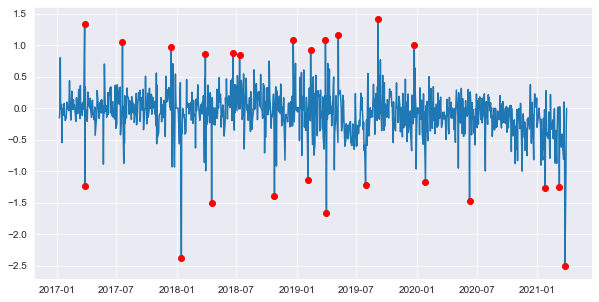

In [224]:
from modules.anomaly import detect_anomalies

anomaly_indexes = detect_anomalies(TS.Balance, thres=0.01, visualize=True)

## Shiryaev-Roberts

Делаем предположение, что тип разладки - смена волатильности, поэтому для обнаружения разладки используем статистику Ширяева-Роберста.

'anomaly'

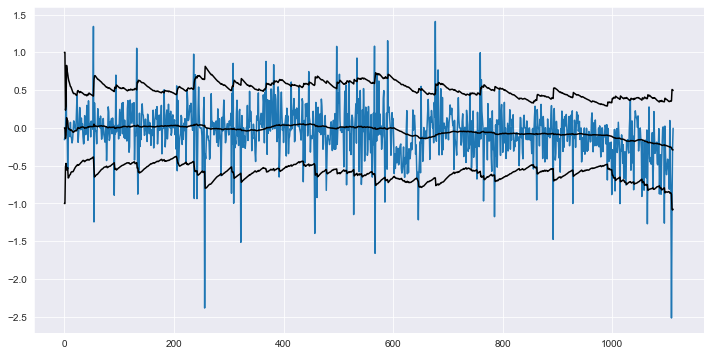

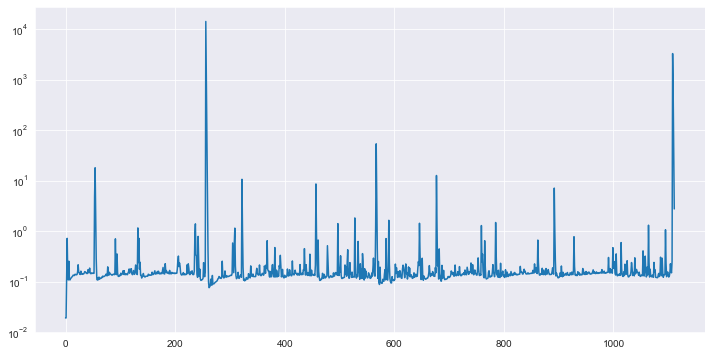

In [238]:
from modules.сhange_point_detection import detection_change_point, add_training_change_point

stat_trajectory = detection_change_point(TS.Balance, visualize=True)
add_training_change_point(stat_trajectory)

## Feature generation

In [254]:
from modules.feature_generation import generate_features

X, y = generate_features(TS[["Balance"]], max_timeshift=14, min_timeshift=7)

Feature Extraction: 100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


## Feature selection

In [10]:
from modules.feature_selection import select_features, test_stability

selected_features = select_features(X, y)

In [14]:
stability = test_stability(X, y, n_iterations=10)
stability

100%|██████████| 10/10 [02:41<00:00, 16.12s/it]


{'OLS recursive': 0.5051672320688885,
 'correlation': 0.6235104669887278,
 'mutual_info': 0.3971401781528362,
 'random_forest': 0.684089364267118,
 'lgbm': 0.6938627299570657,
 'ensemble': 0.6651789851080212}

## Tuning hyperparameters:

In [255]:
from IPython.display import clear_output

from modules.tuner import tune

study = tune(X, y)
clear_output()

In [182]:
study.best_params

{'n_estimators': 755,
 'learning_rate': 0.2251526687356746,
 'num_leaves': 990,
 'max_depth': 5,
 'min_data_in_leaf': 34}

## Modeling

In [186]:
from modules.train import train_model

In [276]:
X, y = generate_features(TS[["Balance"]], max_timeshift=80, min_timeshift=70)

Feature Extraction: 100%|██████████| 20/20 [00:26<00:00,  1.34s/it]


In [277]:
study = tune(X, y)
clear_output()

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
Best MAE: 0.31385328877442026
Best PnL: -0.4439586357234651


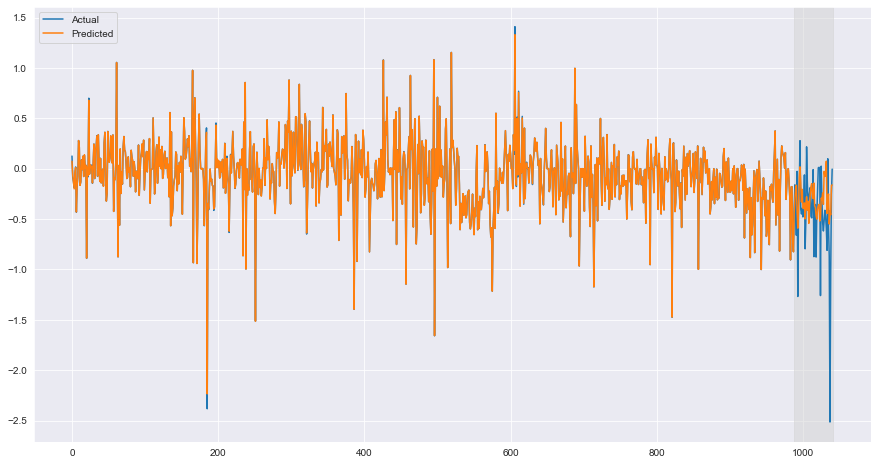

In [278]:
model_params = study.best_params

model = train_model(
    X, y,
    test_size=0.05, visualize=True,
    **model_params
)